this is the nth attempt for doing this 

In [2]:
import numpy as np                  # for basic operations over arrays
from scipy.spatial import distance  # to compute the Gaussian kernel
import cvxopt                       # to solve the dual optimization problem
import copy                         # to copy numpy arrays 


class SVM:
    linear = lambda x, x , c=0: x @ x .T
    polynomial = lambda x, x , Q=5: (1 + x @ x.T)**Q
    rbf = lambda x, xࠤ , γ=10: np.exp(-γ * distance.cdist(x, xࠤ,'sqeuclidean'))
    kernel_funs = {'linear': linear, 'polynomial': polynomial, 'rbf': rbf}
    
    def __init__(self, kernel='rbf', C=1, k=2):
        # set the hyperparameters
        self.kernel_str = kernel
        self.kernel = SVM.kernel_funs[kernel]
        self.C = C                  # regularization parameter
        self.k = k                  # kernel parameter
        
        # training data and support vectors
        self.X, y = None, None
        self.αs = None
        
        # for multi-class classification
        self.multiclass = False
        self.clfs = []                                  

# This is useless here (only for notebook)
SVMClass = lambda func: setattr(SVM, func.__name__, func) or func


@SVMClass
def fit(self, X, y, eval_train=False):
    if len(np.unique(y)) > 2:
        self.multiclass = True
        return self.multi_fit(X, y, eval_train)
    
    # relabel if needed
    if set(np.unique(y)) == {0, 1}: y[y == 0] = -1
    # ensure y has dimensions Nx1
    self.y = y.reshape(-1, 1).astype(np.double) # Has to be a column vector
    self.X = X
    N = X.shape[0]
    
    # compute the kernel over all possible pairs of (x, x') in the data
    self.K = self.kernel(X, X, self.k)
    
    # For 1/2 x^T P x + q^T x
    P = cvxopt.matrix(self.y @ self.y.T * self.K)
    q = cvxopt.matrix(-np.ones((N, 1)))
    
    # For Ax = b
    A = cvxopt.matrix(self.y.T)
    b = cvxopt.matrix(np.zeros(1))

    # For Gx <= h
    G = cvxopt.matrix(np.vstack((-np.identity(N),
                                 np.identity(N))))
    h = cvxopt.matrix(np.vstack((np.zeros((N,1)),
                                 np.ones((N,1)) * self.C)))

    # Solve    
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    self.αs = np.array(sol["x"])
        
    # Maps into support vectors
    self.is_sv = ((self.αs > 1e-3) & (self.αs <= self.C)).squeeze()
    self.margin_sv = np.argmax((1e-3 < self.αs) & (self.αs < self.C - 1e-3))
    
    if eval_train:  
      print(f"Finished training with accuracy {self.evaluate(X, y)}")


@SVMClass
def multi_fit(self, X, y, eval_train=False):
    self.k = len(np.unique(y))      # number of classes
    # for each pair of classes
    for i in range(self.k):
        # get the data for the pair
        Xs, Ys = X, copy.copy(y)
        # change the labels to -1 and 1
        Ys[Ys!=i], Ys[Ys==i] = -1, +1
        # fit the classifier
        clf = SVM(kernel=self.kernel_str, C=self.C, k=self.k)
        clf.fit(Xs, Ys)
        # save the classifier
        self.clfs.append(clf)
    if eval_train:  
      print(f"Finished training with accuracy {self.evaluate(X, y)}")

@SVMClass
def predict(self, X_t):
    if self.multiclass: return self.multi_predict(X_t)
    xₛ, yₛ = self.X[self.margin_sv, np.newaxis], self.y[self.margin_sv]
    αs, y, X= self.αs[self.is_sv], self.y[self.is_sv], self.X[self.is_sv]

    b = yₛ - np.sum(αs * y * self.kernel(X, xₛ, self.k), axis=0)
    score = np.sum(αs * y * self.kernel(X, X_t, self.k), axis=0) + b
    return np.sign(score).astype(int), score

@SVMClass
def multi_predict(self, X):
    # get the predictions from all classifiers
    preds = np.zeros((X.shape[0], self.k))
    for i, clf in enumerate(self.clfs):
        _, preds[:, i] = clf.predict(X)
    
    # get the argmax and the corresponding score
    return np.argmax(preds, axis=1)

@SVMClass
def evaluate(self, X,y):  
    outputs, _ = self.predict(X)
    accuracy = np.sum(outputs == y) / len(y)
    return round(accuracy, 2)


from sklearn.datasets import make_classification
import numpy as np

# Load the dataset
np.random.seed(1)
X, y = make_classification(n_samples=500, n_features=2, 
          n_redundant=0, n_informative=2, n_classes=4, 
          n_clusters_per_class=1,  class_sep=0.3)

# Test SVM
svm = SVM(kernel='rbf', k=4)
svm.fit(X, y, eval_train=True)

y_pred = svm.predict(X)
print(f"Accuracy: {np.sum(y==y_pred)/y.shape[0]}")


# Test with Scikit
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier(SVC(kernel='rbf', C=1, gamma=4)).fit(X, y)
y_pred = clf.predict(X)
print(f"Accuracy: {sum(y==y_pred)/y.shape[0]}")

SyntaxError: duplicate argument 'x' in function definition (2179674569.py, line 8)

33 180
20 20


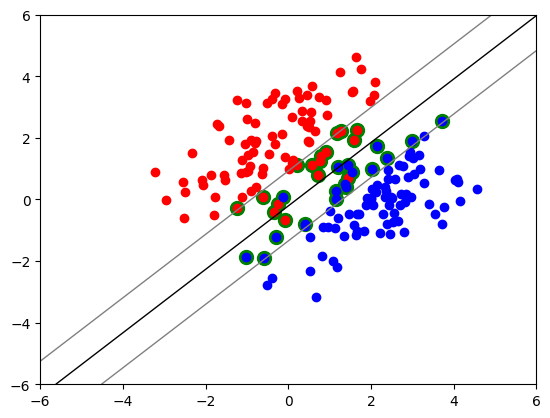

In [4]:
# Mathieu Blondel, September 2010
# License: BSD 3 clause

import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print(len(self.a), n_samples)

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

if __name__ == "__main__":
    import pylab as pl

    def gen_lin_separable_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[0.8, 0.6], [0.6, 0.8]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_non_lin_separable_data():
        mean1 = [-1, 2]
        mean2 = [1, -1]
        mean3 = [4, -4]
        mean4 = [-4, 4]
        cov = [[1.0,0.8], [0.8, 1.0]]
        X1 = np.random.multivariate_normal(mean1, cov, 50)
        X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 50)
        X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_lin_separable_overlap_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[1.5, 1.0], [1.0, 1.5]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def split_train(X1, y1, X2, y2):
        X1_train = X1[:90]
        y1_train = y1[:90]
        X2_train = X2[:90]
        y2_train = y2[:90]
        X_train = np.vstack((X1_train, X2_train))
        y_train = np.hstack((y1_train, y2_train))
        return X_train, y_train

    def split_test(X1, y1, X2, y2):
        X1_test = X1[90:]
        y1_test = y1[90:]
        X2_test = X2[90:]
        y2_test = y2[90:]
        X_test = np.vstack((X1_test, X2_test))
        y_test = np.hstack((y1_test, y2_test))
        return X_test, y_test

    def plot_margin(X1_train, X2_train, clf):
        def f(x, w, b, c=0):
            # given x, return y such that [x,y] in on the line
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]

        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")

        pl.axis("tight")
        pl.show()

    def plot_contour(X1_train, X2_train, clf):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

        pl.axis("tight")
        pl.show()

    def test_linear():
        X1, y1, X2, y2 = gen_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM()
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print(correct, len(y_predict))

        plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)

    def test_non_linear():
        X1, y1, X2, y2 = gen_non_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(gaussian_kernel)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print(correct, len(y_predict))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

    def test_soft():
        X1, y1, X2, y2 = gen_lin_separable_overlap_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(C=0.1)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print(correct, len(y_predict))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

    test_soft()

In [37]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

iris = load_iris()
iris_df = pd.DataFrame(data= np.c_[iris["data"], iris["target"]], columns= iris["feature_names"] + ["target"])

X = iris_df[["petal length (cm)", "petal width (cm)"]].to_numpy()
y = iris_df[["target"]].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y ,random_state=19,test_size=0.2,shuffle=True) 
#print(y.shape)
#X_train.to_numpy()

clf = SVM()
clf.fit(X_train, y_train)
res = clf.predict(X_test)
print(res)
print(y_test)

40 120
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[[0.]
 [2.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [2.]
 [1.]
 [0.]
 [1.]
 [0.]
 [2.]
 [0.]
 [2.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [1.]
 [2.]]
